## Modeling 

In [1]:
import json
from tqdm.auto import tqdm
from glob import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
import os
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
torch.__version__

'2.0.0'

### Data Load

In [3]:
# 여기부터
sorted_notnull_data = np.load('../Data/sorted_notnull_data_train.npy') # ,allow_pickle=True)
sorted_notnull_label = np.load('../Data/sorted_notnull_label_train.npy')

In [4]:
sorted_notnull_data.shape, sorted_notnull_label.shape

((12967, 253, 274), (12967, 707))

In [5]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [12]:
num_epochs = 600
seq_len = 253 # 데이터에 따라 변경
input_size = 274 # 고정 (키포인트)
output_size = 707 # 클래스 개수
# hidden_layer_size = 128
# num_layers = 2
# lr = 0.1
batch_size = 32

In [7]:
import math

# Attention Class
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attn_weights = nn.Parameter(torch.Tensor(1, hidden_size), requires_grad=True)
    
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.attn_weights:
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, inputs):
        # Compute attention scores
        attn_scores = torch.sum(self.attn_weights * inputs, dim=2) # LSTM 출력 그대로 받아서 계산
        
        # Compute attention weights
        attn_weights = F.softmax(attn_scores, dim=1).unsqueeze(1)
        
        # Compute weighted sum of inputs
        weighted_sum = torch.bmm(attn_weights, inputs)
        
        return weighted_sum.squeeze(1)

In [8]:
class MyModel(nn.Module):
    def __init__(self, input_size=274, hidden_layer_size=404, hidden_layer_size2=505, hidden_layer_size3=606, output_size=707, num_layers=3):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.lstm3 = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.5, bidirectional=True)

        self.attention1 = SelfAttention(hidden_layer_size * 2) # Bidirectional LSTM이므로 hidden_layer_size가 2배
        self.attention2 = SelfAttention(hidden_layer_size * 2) # Bidirectional LSTM이므로 hidden_layer_size가 2배
        self.attention3 = SelfAttention(hidden_layer_size * 2)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(hidden_layer_size * 2, hidden_layer_size2) # Bidirectional LSTM이므로 입력 차원이 2배
        self.residual_block = nn.Linear(hidden_layer_size * 2, hidden_layer_size3) # attn_out을 output_size로 변환하는 layer 추가

        self.fc2 = nn.Linear(hidden_layer_size2, hidden_layer_size3)
        self.fc3 = nn.Linear(hidden_layer_size3, output_size)
        

    def forward(self, input_seq):
        lstm_out1, (_, _) = self.lstm1(input_seq)
        lstm_out2, (_, _) = self.lstm2(input_seq)
        lstm_out3, (_, _) = self.lstm3(input_seq)

        attn_out1 = self.attention1(lstm_out1)
        attn_out2 = self.attention2(lstm_out2)
        attn_out3 = self.attention3(lstm_out3)

        # Multi-Head Attention
        attn_out = attn_out1 + attn_out2 + attn_out3

        out = self.fc1(attn_out)
        residual = self.residual_block(attn_out)

        out = self.dropout(out)
        out = self.fc2(out)

        # Residual connection
        out = out + residual
        out = self.dropout(out)
        out = self.fc3(out)

        return out


In [9]:
train_data_torch = torch.tensor(sorted_notnull_data).float()
train_labels_torch = torch.tensor(sorted_notnull_label).long()

In [10]:
dataset = MyDataset(train_data_torch , train_labels_torch)
dataloader = DataLoader(dataset, batch_size)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
model = MyModel().to(device)

/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:173: UserWarning: 
NVIDIA RTX A5000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_60 sm_70 sm_75 compute_70 compute_75.
If you want to use the NVIDIA RTX A5000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
# optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=0.00001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.5)
# optimizer = optim.Adam(model.parameters(), lr = 0)
#scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=100, T_mult=1, eta_max=0.1, T_up=10, gamma=0.5)
print(model)

MyModel(
  (lstm1): LSTM(274, 404, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm2): LSTM(274, 404, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm3): LSTM(274, 404, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (attention1): SelfAttention()
  (attention2): SelfAttention()
  (attention3): SelfAttention()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=808, out_features=505, bias=True)
  (residual_block): Linear(in_features=808, out_features=606, bias=True)
  (fc2): Linear(in_features=505, out_features=606, bias=True)
  (fc3): Linear(in_features=606, out_features=707, bias=True)
)


In [14]:
save_model_name = "LSTM_Attention_final_model.pth"

In [15]:
best_acc = 0.0
best_loss = float('inf')
best_epoch = -1

# Initialize lists to save the history of training loss and accuracy
loss_history = []
accuracy_history = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0.0
    total_predictions = 0.0

    for seq, label in dataloader:
        seq, label = seq.to(device), label.to(device)

        optimizer.zero_grad()

        output = model(seq)

        _, predicted_labels = torch.max(output, 1)

        label_gt = torch.where(label == 1)[1]
        
        correct_predictions += predicted_labels.eq(label_gt).sum().item()
        # correct_predictions += (predicted_labels == label_gt).sum().item()
        total_predictions += len(label_gt)

        loss = criterion(output, label_gt)
        
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item() * len(seq)

    epoch_loss = running_loss / total_predictions
    epoch_acc = correct_predictions / total_predictions

    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Save the model if it has a higher accuracy than our current best
    if epoch_acc > best_acc or (epoch_acc == best_acc and epoch_loss < best_loss):
      best_epoch=epoch+1 
      best_acc=epoch_acc 
      best_loss=epoch_loss
      torch.save(model.state_dict(), f'../checkpoint/{save_model_name}')

    # Step the learning rate scheduler
    scheduler.step()

    # Record this epoch's loss and accuracy values for later visualization.
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_acc)

print("Training complete.")

Epoch 1, Loss: 6.5223, Accuracy: 0.0040
Epoch 2, Loss: 6.8880, Accuracy: 0.0035
Epoch 3, Loss: 7.1495, Accuracy: 0.0052
Epoch 4, Loss: 7.6800, Accuracy: 0.0029
Epoch 5, Loss: 7.6374, Accuracy: 0.0022
Epoch 6, Loss: 7.5949, Accuracy: 0.0022
Epoch 7, Loss: 7.8081, Accuracy: 0.0035
Epoch 8, Loss: 7.6810, Accuracy: 0.0042
Epoch 9, Loss: 7.7768, Accuracy: 0.0043
Epoch 10, Loss: 7.8454, Accuracy: 0.0048
Epoch 11, Loss: 7.8470, Accuracy: 0.0043
Epoch 12, Loss: 8.3226, Accuracy: 0.0023
Epoch 13, Loss: 7.3587, Accuracy: 0.0015
Epoch 14, Loss: 6.8797, Accuracy: 0.0017
Epoch 15, Loss: 6.7996, Accuracy: 0.0022
Epoch 16, Loss: 6.8042, Accuracy: 0.0021
Epoch 17, Loss: 6.8555, Accuracy: 0.0013
Epoch 18, Loss: 6.9017, Accuracy: 0.0009
Epoch 19, Loss: 6.9932, Accuracy: 0.0015
Epoch 20, Loss: 7.2051, Accuracy: 0.0039
Epoch 21, Loss: 7.6383, Accuracy: 0.0026
Epoch 22, Loss: 6.8600, Accuracy: 0.0018
Epoch 23, Loss: 6.6129, Accuracy: 0.0030
Epoch 24, Loss: 6.6000, Accuracy: 0.0031
Epoch 25, Loss: 6.6067, A

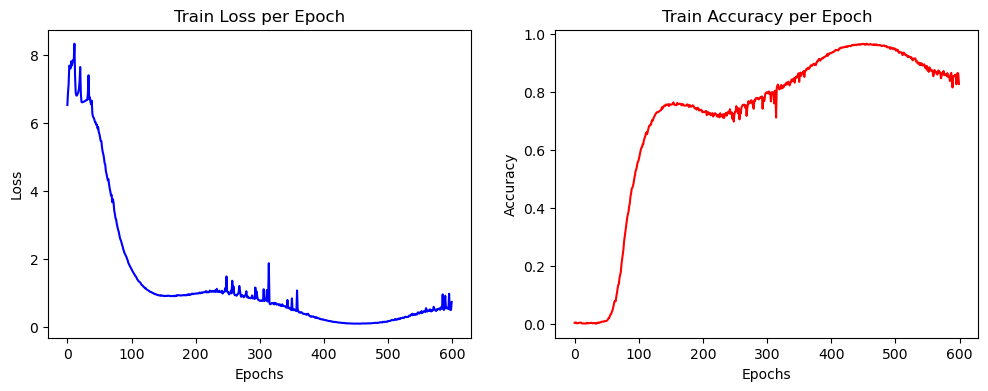

In [16]:
# Loss, Accuracy 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, 'b-')
plt.title('Train Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_history,'r-')
plt.title('Train Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()


In [17]:
# Final Loss and Accuracy
print(f'Final Result Epoch : {best_epoch} Best Accuracy : {best_acc} & Best Loss : {best_loss}')

Final Result Epoch : 456 Best Accuracy : 0.9670702552633609 & Best Loss : 0.09993706209847905


## Test

In [18]:
# data load
sorted_notnull_test_data = np.load('../Data/sorted_notnull_data_test.npy')

# label load 
sorted_notnull_test_label = np.load('../Data/sorted_notnull_label_test.npy')

In [19]:
sorted_notnull_test_data.shape, sorted_notnull_test_label.shape

((1637, 253, 274), (1637, 707))

In [20]:
# seq_len = 253 # 변경
# input_size = 274
# output_size = 707 # 변경
# hidden_layer_size = 128

batch_size = 1

In [21]:
test_data_torch = torch.tensor(sorted_notnull_test_data).float()
test_labels_torch = torch.tensor(sorted_notnull_test_label).long()

test_dataset = MyDataset(test_data_torch , test_labels_torch)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

In [22]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_model = MyModel().to(device)
checkpoint = torch.load(f'../checkpoint/{save_model_name}')
test_model.load_state_dict(checkpoint)
print(test_model)

MyModel(
  (lstm1): LSTM(274, 404, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm2): LSTM(274, 404, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm3): LSTM(274, 404, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (attention1): SelfAttention()
  (attention2): SelfAttention()
  (attention3): SelfAttention()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=808, out_features=505, bias=True)
  (residual_block): Linear(in_features=808, out_features=606, bias=True)
  (fc2): Linear(in_features=505, out_features=606, bias=True)
  (fc3): Linear(in_features=606, out_features=707, bias=True)
)


In [23]:
device

device(type='cuda')

In [24]:
test_model.eval()

with torch.no_grad():
    correct = 0
    total = 0

    for batch_data, batch_labels in test_dataloader:
        # 모델 입력 데이터와 레이블을 GPU 또는 CPU로 이동시킵니다.
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # 모델에 데이터를 전달하여 예측합니다.
        outputs = test_model(batch_data)

        # 확률 분포에서 최댓값을 가지는 클래스를 선택합니다.
        _, predicted = torch.max(outputs, 1)

        label_gt = torch.where(batch_labels == 1)[1]

        # 정확하게 분류된 샘플 수를 업데이트합니다.
        total += batch_labels.size(0)
        correct += predicted.eq(label_gt).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {100 * accuracy:.2f}%')

Accuracy: 90.59%
